In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize

from numba import prange

import sys
sys.path.append("modules/")
import crossfeeding_functions as cfns

In [127]:
plt.style.use("../style1.mplstyle")

In [128]:
Nr = 1
Ns = 1

In [129]:
def binValuesFn(values,logBins=True,nBins=10,density=True):  

    if(logBins):
        positiveVals = values[values > 0]
        negativeVals = -values[values < 0]
        positiveValsBins = np.geomspace(np.min(positiveVals),np.max(positiveVals),nBins)
        negativeValsBins = np.geomspace(np.min(negativeVals),np.max(negativeVals),nBins)
        positiveHist,positiveEdges = np.histogram(positiveVals,bins=positiveValsBins,density=density)
        negativeHist,negativeEdges = np.histogram(negativeVals,bins=negativeValsBins,density=density)

        return positiveHist,positiveEdges,negativeHist,negativeEdges

    else:
        bins = np.linspace(np.min(values),np.max(values),2*nBins)
        hist,edges = np.histogram(values,bins=bins,density=density)

        return hist,edges   

In [130]:
def resUsage(resources,populations,muMatrix, kMatrix, dTensor, delta, supplyVec,Nr,Ns):
    dres = np.zeros(Nr)
    uptakeMatrix = (muMatrix.T * populations).T * resources / (kMatrix + resources)
    resourceUsage = np.sum(uptakeMatrix,axis=0)  
    
    for alpha in prange(Nr):        
        leakage = np.sum(dTensor[:,alpha,:]*uptakeMatrix)            
        dres[alpha] = delta*(supplyVec[alpha] - resources[alpha]) - resourceUsage[alpha] + leakage

    return dres

In [131]:
def qssResourcesSolver(resourceUsageFn,populations,muMatrix, kMatrix, dTensor, delta, supplyVec,Nr,Ns):
    

IndentationError: expected an indented block (2990684873.py, line 2)

In [132]:
leakageRate = 0

unscaledMuMatrix = np.random.lognormal(-1.95,1,(Ns,Nr))
muMatrix = (1-leakageRate) * unscaledMuMatrix / np.max(unscaledMuMatrix)

kMatrix = np.random.lognormal(5.5, 1.2,(Ns,Nr))/1000

unscaledDTensor = np.random.lognormal(-8.78, 2.75,(Ns,Nr,Nr))
dTensor = 0.9* leakageRate *unscaledDTensor / np.max(unscaledDTensor)
# dTensor = np.zeros((Ns,Nr,Nr))
# dTensor = leakageRate * unscaledDTensor / np.sum(unscaledDTensor,axis=2)[:,:,np.newaxis]

supplyVec = np.full(Nr,10)
delta = 0.2

cfns.assertParams(muMatrix,kMatrix,dTensor,delta,supplyVec,Ns=Ns,Nr=Nr)

rVecBeginning = supplyVec.copy()
rVecEnd = np.random.lognormal(np.mean(kMatrix)/np.mean(supplyVec),1,Nr)


In [133]:
initialPopulations,muMatrix, kMatrix, dTensor, delta, supplyVec,Nr,Ns

(array([0.05]),
 array([[1.]]),
 array([[0.07308738]]),
 array([[[0.]]]),
 0.2,
 array([10]),
 1,
 1)

In [134]:
qssSolution = optimize.least_squares(resUsage,rVecBeginning,args=(initialPopulations,muMatrix, kMatrix, dTensor, delta, supplyVec,Nr,Ns))

In [135]:
growthVecBeginning,interactionMatrixBeginning = cfns.glvParamsFn(muMatrix,kMatrix,dTensor,qssSolution.x,delta,supplyVec,Nr,Ns)

In [136]:
growthVecBeginning

array([-0.00018791])

In [137]:
interactionMatrixBeginning

array([[-0.0037583]])

In [138]:
nBins = 1

growthBeginHist,growthBeginEdges = binValuesFn(growthVecBeginning,density=False,logBins=False,nBins=nBins)
growthBeginCentres = (growthBeginEdges[:-1]+growthBeginEdges[1:])/2

intBegHistPos,intBegEdgesPos,intBegHistNeg,intBegEdgesNeg = binValuesFn(interactionMatrixBeginning.flatten(),density=False,logBins=True,nBins=5*nBins)
intBegCentresPos = (intBegEdgesPos[:-1]+intBegEdgesPos[1:])/2
intBegCentresNeg = (intBegEdgesNeg[:-1]+intBegEdgesNeg[1:])/2

ValueError: zero-size array to reduction operation minimum which has no identity

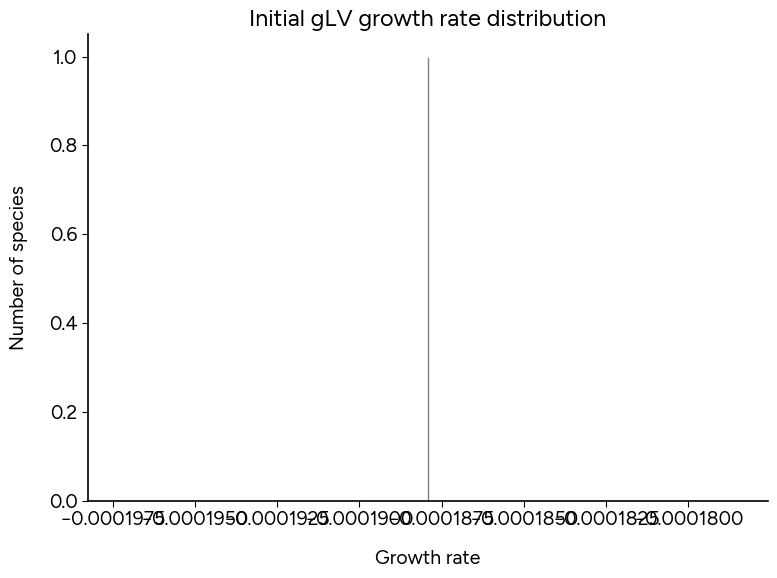

In [139]:
plt.bar(growthBeginCentres,growthBeginHist,width=np.diff(growthBeginEdges)*0.8,align="center",edgecolor="black",alpha=0.5)

plt.xlabel("Growth rate")
plt.ylabel("Number of species")
plt.title("Initial gLV growth rate distribution")

plt.show()

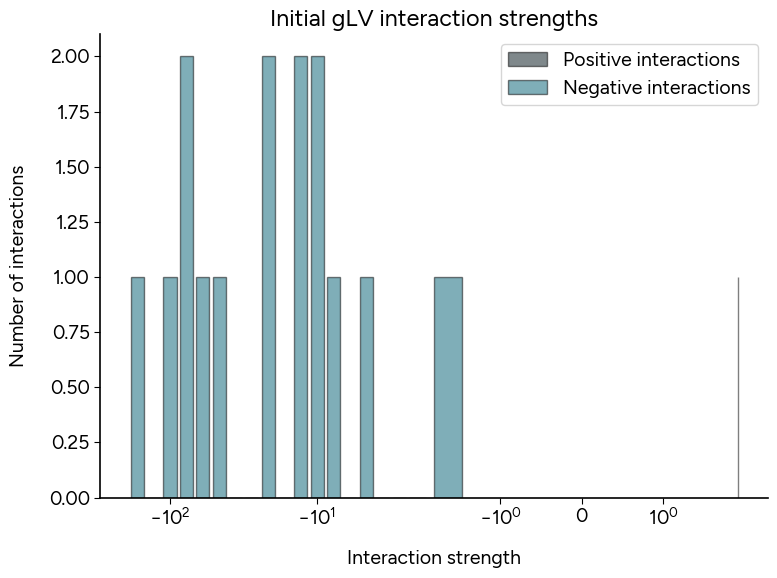

In [140]:
plt.bar(intBegCentresPos,intBegHistPos,width=np.diff(intBegEdgesPos)*0.8,align="center",edgecolor="black",alpha=0.5,label="Positive interactions")
plt.bar(-intBegCentresNeg,intBegHistNeg,width=np.diff(intBegEdgesNeg)*0.8,align="center",edgecolor="black",alpha=0.5,label="Negative interactions")


plt.xlabel("Interaction strength")
plt.ylabel("Number of interactions")
plt.title("Initial gLV interaction strengths")

plt.legend()
plt.xscale("symlog")
plt.show()

In [141]:
initialPopulations = np.full(Ns,0.05)
# initialPopulations = np.zeros(Ns)
# initialPopulations[3] = 0.05
initialResources = supplyVec

initialConditions = np.concatenate((initialPopulations,initialResources))

t = np.linspace(0,72,1000)

In [142]:
initialConditions

array([ 0.05, 10.  ])

In [143]:
%%time 
sol = integrate.solve_ivp(cfns.chemostat_dynamics,(0,t[-1]),initialConditions,args=(muMatrix, kMatrix, dTensor, delta, supplyVec,Nr,Ns),t_eval=t,max_step=0.1)

CPU times: total: 8.22 s
Wall time: 10.1 s


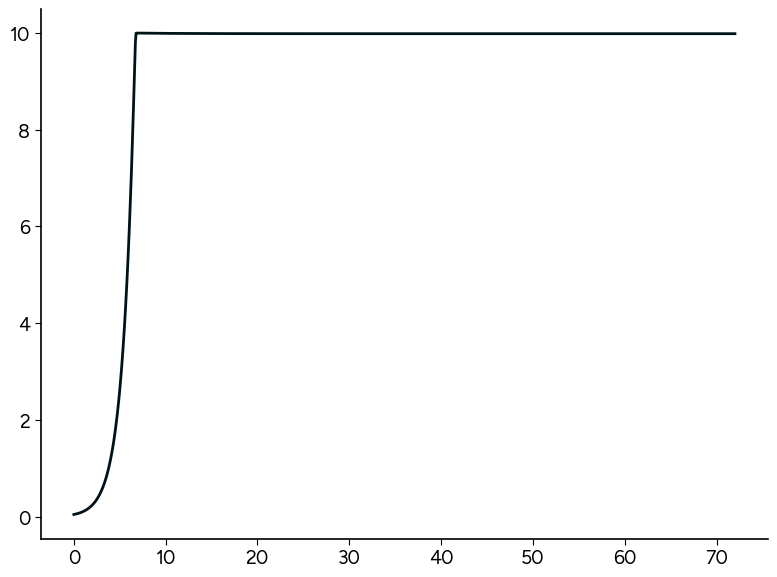

In [144]:
plt.plot(sol.t,sol.y[:Ns].T)

# plt.yscale("log")
plt.show()

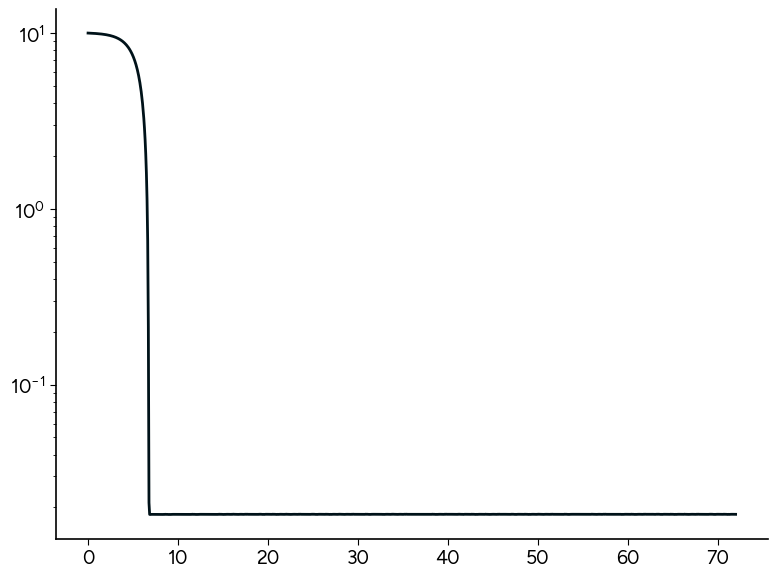

In [145]:
plt.plot(sol.t,sol.y[Ns:].T)

plt.yscale("log")
plt.show()

In [146]:
qssSolutionEnd = optimize.least_squares(resUsage,sol.y[Ns:,-1],args=(sol.y[:Ns,-1],muMatrix, kMatrix, dTensor, delta, supplyVec,Nr,Ns))

In [147]:
fVec = cfns.fVectorFn(supplyVec,qssSolutionEnd.x,delta,Nr,Ns)
eMatrix = cfns.eMatrixFn(muMatrix,kMatrix,dTensor,qssSolutionEnd.x,Nr,Ns)
sMatrix = cfns.sMatrixFn(muMatrix,kMatrix,qssSolutionEnd.x,Nr,Ns)
mMatrix = cfns.mMatrixFn(muMatrix,kMatrix,dTensor,qssSolutionEnd.x,delta,supplyVec,Nr,Ns)
mInv = np.linalg.inv(mMatrix)

growthVec = np.dot(sMatrix.T,np.dot(mInv,fVec))
interactionMatrix = np.dot(-sMatrix.T,np.dot(mInv,eMatrix))

In [148]:
qssSolutionEnd.x

array([0.01827185])

In [149]:
fVec

array([1.99634563])

In [150]:
growthVecEnd,interactionMatrixEnd = cfns.glvParamsFn(muMatrix,kMatrix,dTensor,qssSolutionEnd.x,delta,supplyVec,Nr,Ns)

In [151]:
qssCvsT = np.zeros((len(sol.t),Nr))
for i in range(len(sol.t)):
    curPop = sol.y[:Ns,i]
    curRes = sol.y[Ns:,i]
    curQssSol = optimize.least_squares(resUsage,curRes,args=(curPop,muMatrix, kMatrix, dTensor, delta, supplyVec,Nr,Ns))
    qssCvsT[i] = curQssSol.x

In [152]:
tdepGrowth,tdepInter = np.zeros((len(sol.t),Ns)),np.zeros((len(sol.t),Ns,Ns))

for i in range(len(sol.t)):
    tdepGrowth[i],tdepInter[i] = cfns.glvParamsFn(muMatrix,kMatrix,dTensor,qssCvsT[i],delta,supplyVec,Nr,Ns)

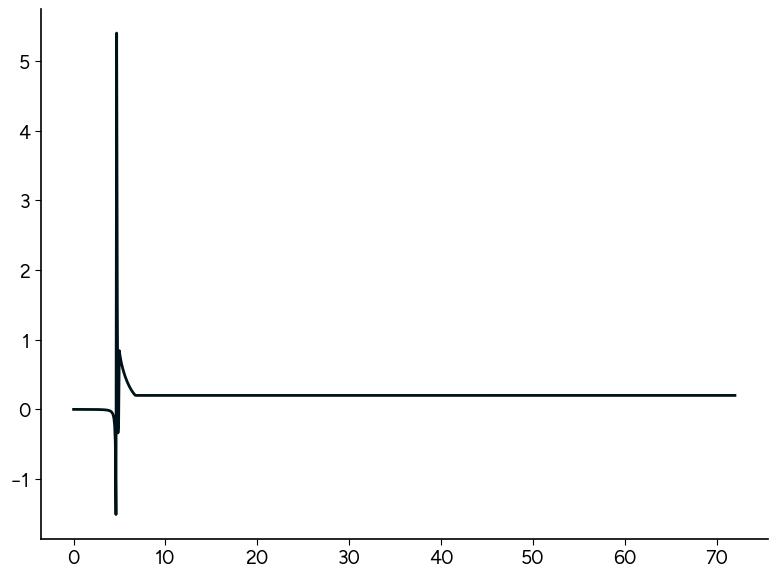

In [153]:
plt.plot(sol.t,tdepGrowth)

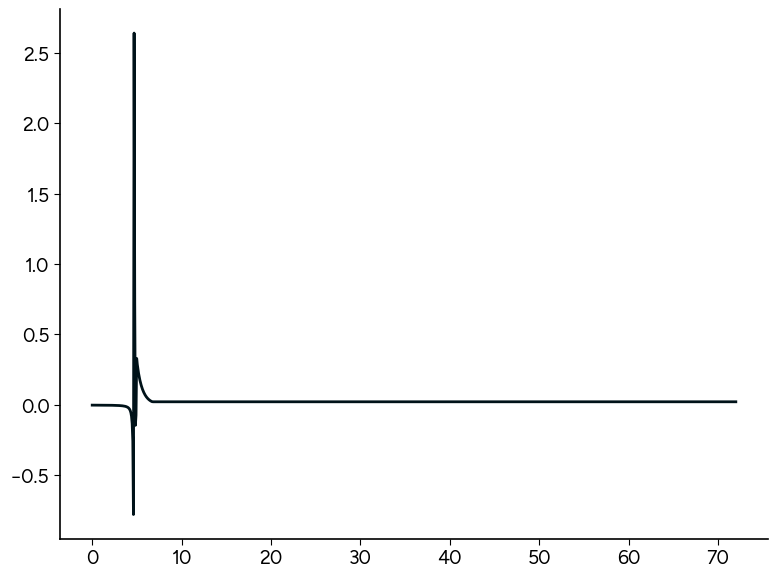

In [154]:
plt.plot(sol.t,tdepInter[:,0,0])


In [361]:
rVecEndHist,rVecEndEdges = binValuesFn(np.log(rVecEnd),density=False,logBins=False,nBins=10)
rVecEndCentres = (rVecEndEdges[:-1]+rVecEndEdges[1:])/2

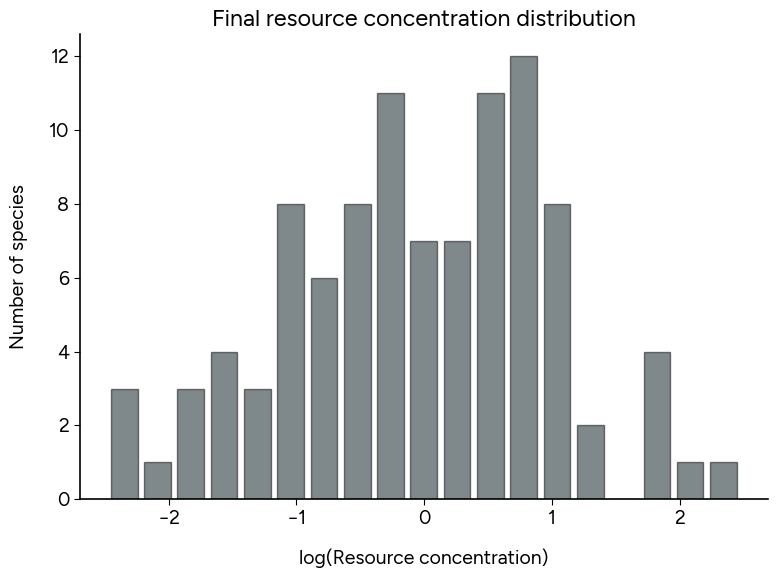

In [362]:
plt.bar(rVecEndCentres,rVecEndHist,width=np.diff(rVecEndEdges)*0.8,align="center",edgecolor="black",alpha=0.5)

plt.xlabel("log(Resource concentration)")
plt.ylabel("Number of species")

plt.title("Final resource concentration distribution")

plt.show()

In [363]:
growthVecEnd,interactionMatrixEnd = glvParamsFn(muMatrix,kMatrix,dTensor,rVecEnd,delta,supplyVec)

In [364]:
growthEndHist,growthEndEdges = binValuesFn(growthVecEnd,density=False,logBins=False,nBins=nBins)
growthEndCentres = (growthEndEdges[:-1]+growthEndEdges[1:])/2

intEndHistPos,intEndEdgesPos,intEndHistNeg,intEndEdgesNeg = binValuesFn(interactionMatrixEnd.flatten(),density=False,logBins=True,nBins=nBins*5)
intEndCentresPos = (intEndEdgesPos[:-1]+intEndEdgesPos[1:])/2
intEndCentresNeg = (intEndEdgesNeg[:-1]+intEndEdgesNeg[1:])/2

interactionEndHist,interactionEndEdges = binValuesFn(interactionMatrixEnd.flatten(),density=False,logBins=False,nBins=nBins*5)
interactionEndCentres = (interactionEndEdges[:-1]+interactionEndEdges[1:])/2

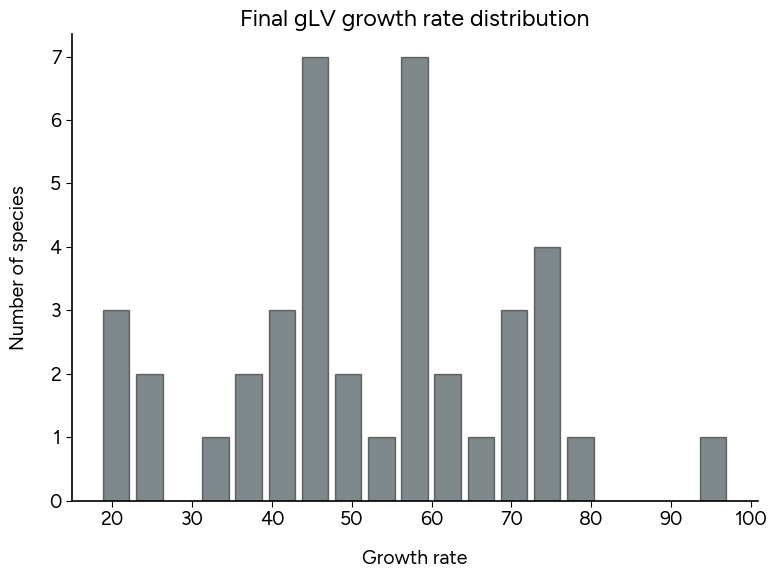

In [365]:
plt.bar(growthEndCentres,growthEndHist,width=np.diff(growthEndEdges)*0.8,align="center",edgecolor="black",alpha=0.5)

plt.xlabel("Growth rate")
plt.ylabel("Number of species")

plt.title("Final gLV growth rate distribution")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


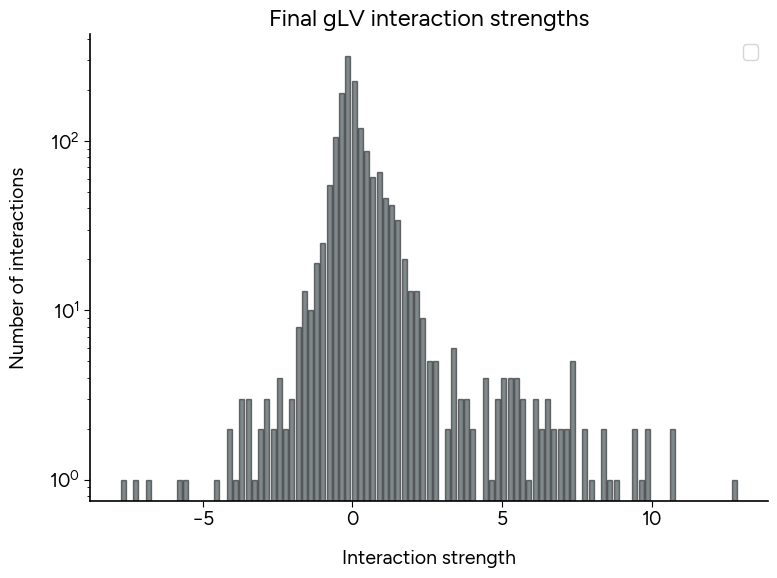

In [368]:
# plt.bar(intEndCentresPos,intEndHistPos,width=np.diff(intEndEdgesPos)*0.8,align="center",edgecolor="black",alpha=0.5,label="Positive interactions")
# plt.bar(-intEndCentresNeg,intEndHistNeg,width=np.diff(intEndEdgesNeg)*0.8,align="center",edgecolor="black",alpha=0.5,label="Negative interactions")
# plt.xscale("symlog")

plt.bar(interactionEndCentres,interactionEndHist,width=np.diff(interactionEndEdges)*0.8,align="center",edgecolor="black",alpha=0.5)
plt.yscale("log")

plt.xlabel("Interaction strength")
plt.ylabel("Number of interactions")

plt.title("Final gLV interaction strengths")

plt.legend()


plt.show()

In [190]:
growthVec,interactionMatrix = glvParamsFn(muMatrix,kMatrix,dTensor,supplyVec,delta,supplyVec*0.9)

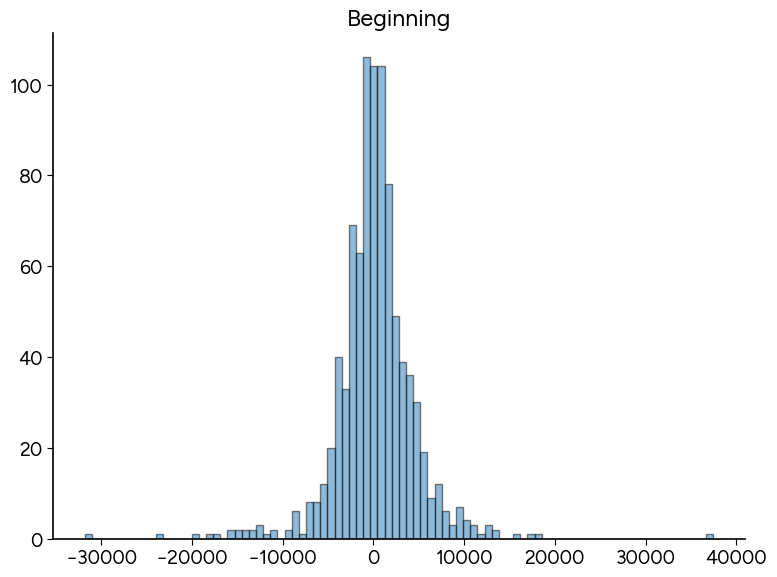

In [191]:
plt.hist(interactionMatrix.flatten(),bins="auto",color="tab:blue",alpha=0.5,edgecolor="black")

plt.title("Beginning")
plt.show()

In [171]:
dTensor =  np.zeros((Ns,Nr,Nr))
growthVec,interactionMatrix = glvParamsFn(muMatrix,kMatrix,dTensor,rVec,delta,supplyVec)

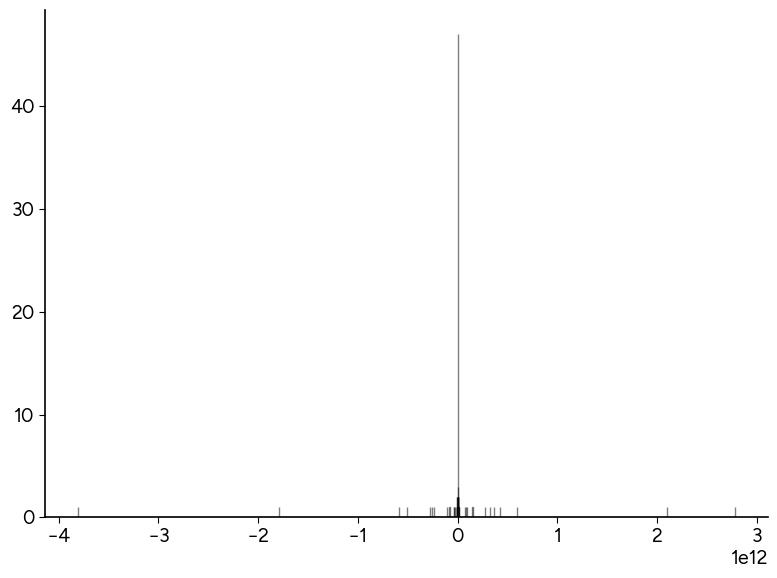

In [172]:
plt.hist(interactionMatrix.flatten(),bins="auto",color="tab:blue",alpha=0.5,edgecolor="black")

plt.show()

In [148]:
initialPopulations = np.random.uniform(0,1,Ns)
initialResources = np.random.uniform(0,1,Nr)

initialConditions = np.concatenate((initialPopulations,initialResources))

t = np.linspace(0,100,1000)

In [149]:
sol = integrate.solve_ivp(chemostat_dynamics,(0,t[-1]),initialConditions,args=(muMatrix, kMatrix, dTensor, delta, supplyVec),t_eval=t)

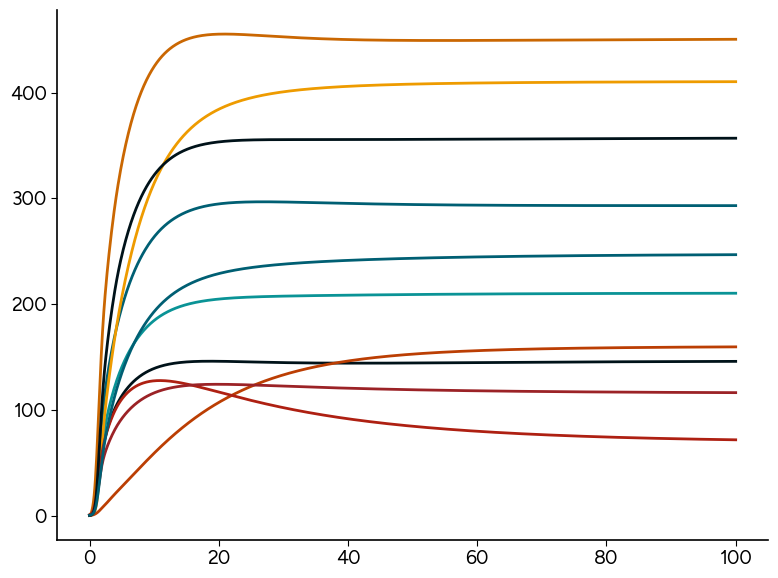

In [150]:
plt.plot(sol.t,sol.y[:Ns].T)

plt.show()

In [156]:
minresconc = np.min(sol.y[Ns:,-1])
maxresconc = np.max(sol.y[Ns:,-1])
bins = np.geomspace(minresconc,maxresconc,20)

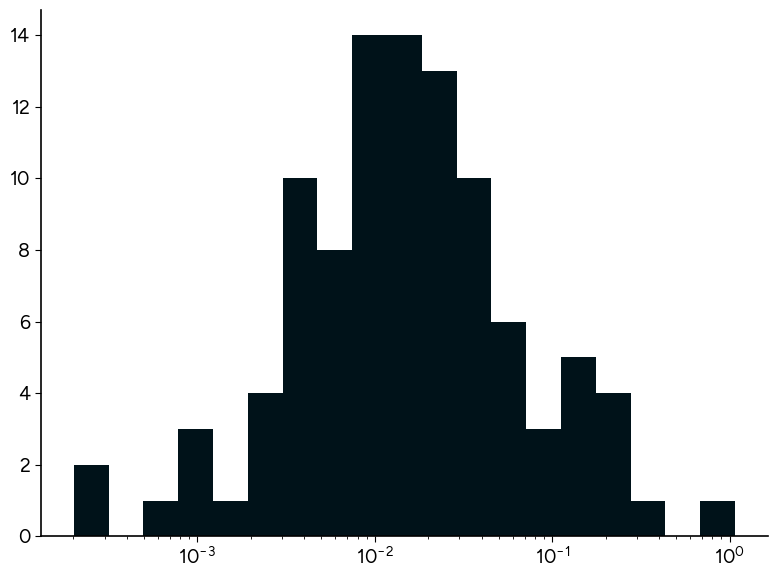

In [158]:
plt.hist(sol.y[Ns:,-1],bins=bins)

plt.xscale("log")
plt.show()